In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np

In [3]:
data = loadmat("fMRI4regionsNN.mat")

/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


## Loading the train dataset

In [4]:
from sklearn.preprocessing import StandardScaler
# We need to standarize the data before we feed it to neural network
scaler = StandardScaler()

In [5]:
X = torch.tensor(scaler.fit_transform(data['train4regions'].reshape(162,-1)), dtype= torch.float32)
y = torch.tensor(data['trainIsFace'].reshape(-1), dtype=torch.uint8).float()

## Defining Our Neural Network

In [6]:
from torch.optim.lr_scheduler import StepLR


In [7]:
class SimpleNN(nn.Module):
    """
    A simple 3 layer NN with dropout. 
    Activation function: Relu on first 2 and sigmoid on output layer
    """
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(4,32)
        self.fc2 = nn.Linear(32,16)
        self.dropout = nn.Dropout(p=0.15)  # Dropout layer with 20% drop probability

        self.fc3 = nn.Linear(16,1)

    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x
    

In [8]:
net = SimpleNN()
criterion = nn.BCELoss() # Loss function: Binary cross-entrophy
optimizer = optim.Adam(net.parameters(), lr = 0.1 ) # optimizer: Adam
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Decay LR by a factor of 0.1 every 10 epochs

## Train

In [9]:
losses = []
for epoch in range(200):
    optimizer.zero_grad()
    output = net(X)
    loss = criterion(output.squeeze(),y)
    # print(f'Epoch {epoch + 1}: Loss = {loss.item()}')  # Print the loss for this epoch
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()  # Update the learning rate


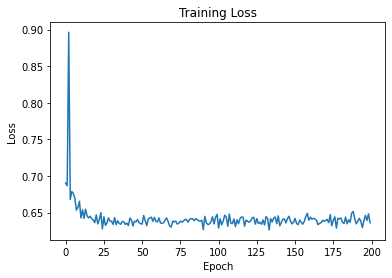

In [10]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Test

In [11]:
X_test = torch.tensor(scaler.transform(data['test4regions'].reshape(-1,4)), dtype= torch.float32)
y_test = torch.tensor(data['testIsFace'].reshape(-1), dtype=torch.uint8).float()

In [12]:
# Test the network
with torch.no_grad():
    test_output = net(X_test)
    predicted = (test_output.squeeze() > 0.5).float()
    accuracy = (predicted == y_test).float().mean()
    print('Accuracy: ', accuracy.item())

Accuracy:  0.5925925970077515


In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted)
print(cm)

[[14 13]
 [ 9 18]]


## Calculate Forward Pass Value

In [17]:
import torch.nn.functional as F

In [14]:
fc1_weights = net.fc1.weight.data
fc1_biases = net.fc1.bias.data
fc2_weights = net.fc2.weight.data
fc2_biases = net.fc2.bias.data


In [21]:
z1 = torch.mm(X, fc1_weights.t()) + fc1_biases  # Linear transformation
a1 = F.relu(z1)  # Output of first layer
print(a1)

tensor([[0.4014, 0.0000, 0.9762,  ..., 0.0000, 1.2566, 0.2059],
        [0.2635, 0.0000, 0.6944,  ..., 0.0000, 0.9091, 0.0017],
        [0.3667, 0.0000, 0.6761,  ..., 0.0000, 1.1650, 0.0862],
        ...,
        [0.0000, 0.0533, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3722, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5054, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [22]:
z2 = torch.mm(a1, fc2_weights.t()) + fc2_biases  # Linear transformation
a2 = F.relu(z2) # output of the second layer
print(a2)

tensor([[1.5194, 0.0000, 1.1454,  ..., 0.0000, 2.5553, 0.0000],
        [0.5697, 0.0000, 0.4305,  ..., 0.0000, 1.5776, 0.0000],
        [0.7873, 0.0000, 0.4089,  ..., 0.0000, 1.8264, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
